In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

In [2]:
!pip install -q 'ray[tune]' 'ray[default]'
!pip install -q --upgrade aioredis==1.3.1

# Initialisation TPU

Les TPU sont des calculateurs qui sont différents du processeur local exécutant le programme Python. Pour travailler avec les TPU, il faut donc commencer par se connecter au cluster distant et les initialiser.

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()


tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Le dataset utilisé est SP500...

**1. Chargement des fichiers CSV**

In [4]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/SPX2010_2021.csv"
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/VIX2010_2021.csv"
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/US10Y2010_2021.csv"
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/TYVIX2010_2021.csv"


rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   179  100   179    0     0   1335      0 --:--:-- --:--:-- --:--:--  1335
100  120k  100  120k    0     0   511k      0 --:--:-- --:--:-- --:--:-- 2110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   179  100   179    0     0   1479      0 --:--:-- --:--:-- --:--:--  1479
100 88447  100 88447    0     0   332k      0 --:--:-- --:--:-- --:--:-- 1877k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0   1521      0 --:--:-- --:--:-- --:--:--  1521
100 89100  100 89100    0     0   410k      0 --:--:-- --:--:-- --:--:-- 8764k

**2. Analyse et correction des données S&P500**

In [5]:
# Création de la série sous Pandas
df_SP500 = pd.read_csv("SPX2010_2021.csv",sep=";",names=["Date","SP500_O","SP500_H","SP500_L","SP500_C"],decimal=",")
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])
df_SP500 = df_SP500.set_index("Date")
df_SP500 = df_SP500.asfreq(freq="1D")
df_SP500

,SP500_O,SP500_H,SP500_L,SP500_C
Date,,,,
2010-01-04,1116.56,1133.87,1116.56,1132.99
2010-01-05,1132.66,1136.63,1129.66,1136.52
2010-01-06,1135.71,1139.18,1133.94,1137.14
2010-01-07,1136.27,1142.46,1131.31,1141.68
2010-01-08,1140.52,1145.39,1136.22,1144.98
...,...,...,...,...
2021-07-17,NaN,NaN,NaN,NaN
2021-07-18,NaN,NaN,NaN,NaN
2021-07-19,4296.40,4296.40,4233.13,4258.49


In [6]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_SP500),len(df_SP500)+1),y=df_SP500['SP500_C'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**2. Analyse et correction des données VIX**

In [7]:
# Création de la série sous Pandas
df_VIX = pd.read_csv("VIX2010_2021.csv",sep=";",names=["Date","VIX_O","VIX_H","VIX_L","VIX_C"],decimal=",")
df_VIX['Date'] = pd.to_datetime(df_VIX['Date'])
df_VIX = df_VIX.set_index("Date")
df_VIX = df_VIX.asfreq(freq="1D")
df_VIX

,VIX_O,VIX_H,VIX_L,VIX_C
Date,,,,
2011-01-03,17.94,17.95,16.91,17.61
2011-01-04,17.34,18.24,17.33,17.38
2011-01-05,17.81,17.95,16.86,17.02
2011-01-06,16.80,17.56,16.79,17.40
2011-01-07,17.31,18.07,16.57,17.14
...,...,...,...,...
2021-07-17,NaN,NaN,NaN,NaN
2021-07-18,NaN,NaN,NaN,NaN
2021-07-19,19.61,25.09,19.27,22.50


In [8]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_VIX),len(df_VIX)+1),y=df_VIX['VIX_C'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**3. Analyse et correction des données US10Y**

In [9]:
# Création de la série sous Pandas
df_US10Y= pd.read_csv("US10Y2010_2021.csv",sep=";",names=["Date","US10Y_O","US10Y_H","US10Y_L","US10Y_C"],decimal=",")
df_US10Y['Date'] = pd.to_datetime(df_US10Y['Date'])
df_US10Y = df_US10Y.set_index("Date")
df_US10Y = df_US10Y.asfreq(freq="1D")
df_US10Y

,US10Y_O,US10Y_H,US10Y_L,US10Y_C
Date,,,,
2010-01-08,3.83,3.86,3.75,3.84
2010-01-09,NaN,NaN,NaN,NaN
2010-01-10,NaN,NaN,NaN,NaN
2010-01-11,3.83,3.85,3.79,3.81
2010-01-12,3.81,3.81,3.72,3.73
...,...,...,...,...
2021-07-17,1.30,1.31,1.29,1.30
2021-07-18,NaN,NaN,NaN,NaN
2021-07-19,1.29,1.30,1.18,1.19


In [10]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_US10Y),len(df_US10Y)+1),y=df_US10Y['US10Y_C'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**4. Analyse et correction des données TYVIX**

In [11]:
# Création de la série sous Pandas
df_TYVIX= pd.read_csv("TYVIX2010_2021.csv",sep=";",names=["Date","TYVIX_C"],decimal=",")
df_TYVIX['Date'] = pd.to_datetime(df_TYVIX['Date'])
df_TYVIX = df_TYVIX.set_index("Date")
df_TYVIX = df_TYVIX.asfreq(freq="1D")
df_TYVIX

,TYVIX_C
Date,
2010-01-04,7.20
2010-01-05,6.95
2010-01-06,7.10
2010-01-07,7.06
2010-01-08,6.49
...,...
2020-04-20,7.06
2020-04-21,7.19
2020-04-22,6.70


In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_TYVIX),len(df_TYVIX)+1),y=df_TYVIX['TYVIX_C'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5. Fusion des données et correction des valeurs NaN**

In [13]:
from functools import reduce

df_liste = [df_SP500,df_VIX,df_US10Y,df_TYVIX]

df_etude = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), df_liste)
df_etude

,SP500_O,SP500_H,SP500_L,SP500_C,VIX_O,VIX_H,VIX_L,VIX_C,US10Y_O,US10Y_H,US10Y_L,US10Y_C,TYVIX_C
Date,,,,,,,,,,,,,
2010-01-04,1116.56,1133.87,1116.56,1132.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.20
2010-01-05,1132.66,1136.63,1129.66,1136.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.95
2010-01-06,1135.71,1139.18,1133.94,1137.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.10
2010-01-07,1136.27,1142.46,1131.31,1141.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.06
2010-01-08,1140.52,1145.39,1136.22,1144.98,NaN,NaN,NaN,NaN,3.83,3.86,3.75,3.84,6.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,1.31,1.29,1.30,NaN
2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-19,4296.40,4296.40,4233.13,4258.49,19.61,25.09,19.27,22.50,1.29,1.30,1.18,1.19,NaN


In [14]:
debut = "2011-01-10"
#debut = "2015-01-01"
fin = "2020-04-24"

mask = (df_etude.index >= debut) & (df_etude.index <= fin)
df_etude = df_etude.loc[mask]
df_etude

,SP500_O,SP500_H,SP500_L,SP500_C,VIX_O,VIX_H,VIX_L,VIX_C,US10Y_O,US10Y_H,US10Y_L,US10Y_C,TYVIX_C
Date,,,,,,,,,,,,,
2011-01-10,1270.84,1271.52,1262.18,1269.75,18.35,18.63,17.54,17.54,3.33,3.34,3.27,3.30,7.99
2011-01-11,1272.58,1277.25,1269.62,1274.48,16.61,17.35,16.60,16.89,3.29,3.36,3.27,3.35,7.94
2011-01-12,1275.65,1286.87,1275.65,1285.96,16.26,16.50,16.17,16.24,3.34,3.42,3.32,3.41,7.75
2011-01-13,1285.78,1286.70,1280.47,1283.76,16.51,16.78,16.14,16.39,3.37,3.39,3.33,3.37,7.70
2011-01-14,1282.90,1293.24,1281.24,1293.24,16.67,16.71,15.37,15.46,3.31,3.34,3.25,3.28,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,2845.62,2868.98,2820.43,2823.16,40.68,43.83,39.88,43.83,0.64,0.65,0.60,0.61,7.06
2020-04-21,2784.81,2785.54,2727.10,2736.56,44.28,47.77,43.77,45.41,0.61,0.62,0.54,0.57,7.19
2020-04-22,2787.89,2815.10,2775.95,2799.31,44.91,45.07,41.41,41.98,0.57,0.64,0.55,0.63,6.70


In [15]:
df_etude.isna().sum()

SP500_O    1030
SP500_H    1030
SP500_L    1030
SP500_C    1030
VIX_O      1019
VIX_H      1019
VIX_L      1019
VIX_C      1019
US10Y_O    1055
US10Y_H    1055
US10Y_L    1055
US10Y_C    1055
TYVIX_C    1052
dtype: int64

In [16]:
df_etude = df_etude.interpolate(method="linear")
df_etude.isna().sum()

SP500_O    0
SP500_H    0
SP500_L    0
SP500_C    0
VIX_O      0
VIX_H      0
VIX_L      0
VIX_C      0
US10Y_O    0
US10Y_H    0
US10Y_L    0
US10Y_C    0
TYVIX_C    0
dtype: int64

Déplace la cible à la fin :

In [17]:
col = df_etude.pop('SP500_C')
df_etude.insert(len(df_etude.columns),"SP500_C",col)
df_etude

,SP500_O,SP500_H,SP500_L,VIX_O,VIX_H,VIX_L,VIX_C,US10Y_O,US10Y_H,US10Y_L,US10Y_C,TYVIX_C,SP500_C
Date,,,,,,,,,,,,,
2011-01-10,1270.84,1271.52,1262.18,18.35,18.63,17.54,17.54,3.33,3.34,3.27,3.30,7.99,1269.75
2011-01-11,1272.58,1277.25,1269.62,16.61,17.35,16.60,16.89,3.29,3.36,3.27,3.35,7.94,1274.48
2011-01-12,1275.65,1286.87,1275.65,16.26,16.50,16.17,16.24,3.34,3.42,3.32,3.41,7.75,1285.96
2011-01-13,1285.78,1286.70,1280.47,16.51,16.78,16.14,16.39,3.37,3.39,3.33,3.37,7.70,1283.76
2011-01-14,1282.90,1293.24,1281.24,16.67,16.71,15.37,15.46,3.31,3.34,3.25,3.28,7.66,1293.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,2845.62,2868.98,2820.43,40.68,43.83,39.88,43.83,0.64,0.65,0.60,0.61,7.06,2823.16
2020-04-21,2784.81,2785.54,2727.10,44.28,47.77,43.77,45.41,0.61,0.62,0.54,0.57,7.19,2736.56
2020-04-22,2787.89,2815.10,2775.95,44.91,45.07,41.41,41.98,0.57,0.64,0.55,0.63,6.70,2799.31


In [18]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['SP500_C'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [19]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2714
Taille de la validation : 679


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [20]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [21]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2714, 13)
(679, 13)


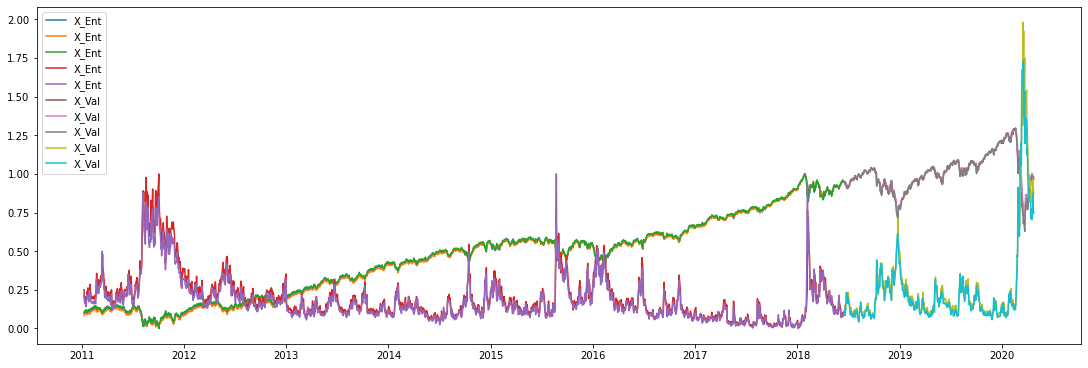

In [22]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [23]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [24]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 256                 
longueur_sequence = 5
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [25]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

10
(256, 5, 12)
(256, 5, 1)
(256, 1, 1)


In [26]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

2
(256, 5, 12)
(256, 5, 1)
(256, 1, 1)


**3. Préparation des X/Y**

In [27]:
def Create_train(dataset):
  X1 = []
  X2 = []

  # Extrait les X,Y du dataset
  x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                          # y=43x(BS,1,1)
  for i in range(len(x)):
    X1.append(x[i][0])          
    X2.append(x[i][1])

  X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
  X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

  X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
  X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

  # Recombine les données
  y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
  X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
  X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

  x_train = [X1,X2]
  y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

  return x_train,y_train

In [28]:
x_train, y_train = Create_train(dataset)
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)

(2560, 5, 12)
(2560, 5, 1)
(2560, 1, 1)


In [29]:
def Create_val(dataset_val):
  X1 = []
  X2 = []

  # Extrait les X,Y du dataset
  x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                          # y=43x(BS,1,1)
  for i in range(len(x)):
    X1.append(x[i][0])          
    X2.append(x[i][1])

  X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
  X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

  X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
  X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

  # Recombine les données
  y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
  X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
  X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

  x_val = [X1,X2]
  y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

  return x_val,y_val

In [30]:
x_val,y_val = Create_val(dataset_val)
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)

(512, 5, 12)
(512, 5, 1)
(512, 1, 1)


# Création du modèle DSTP-RNN #1

Le modèle DSTP-RNN implanté est le suivant :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/DSTPRNN-VueEnsemble.png?raw=true'>

**1. Création de la couche d'attention spatiale de l'étage n°1 / Phase 1**

On commence par créer la couche permettant de calculer le score. Cette fonction calcule le score de l'encodeur, c'est-à-dire le score à attribuer à chaque série d'entrée.  
Cette fonction est appellée par l'encodeur à l'aide de la méthode TimeDistribued de Keras, pour chaque série d'entrée.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScore__.png?raw=true' width=900>

In [31]:
class CalculScores_Encodeur_Phase1(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM_enc_P1):
    self.dim_LSTM_enc_P1 = dim_LSTM_enc_P1
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.Wf = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM_enc_P1),initializer="normal",name="Wf")     # (Tin, 2x#LSTM_encP1)
    self.Uf = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Uf")             # (Tin, Tin)
    self.bf = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="bf")                          # (Tin, 1)
    self.vf = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="vf")                          # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()
    

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTM_encP1)
  #     cell_state:     Cell state          : (batch_size,#LSTM_encP1)]

  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,1)
  # Sorties :
  #     score:          Score               : (batch_size,1,1)

  def call(self, input):
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM_encP1)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM_encP1) => (batch_size,2#LSTM_encP1,1)
        e = tf.matmul(self.Wf,hs)                                               # (Tin,2x#LSTM_encP1)x(batch_size,2x#LSTM_encP1,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Uf,input)                                        # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bf                                                         # (batch_size,Tin,1)
    else:
        e = tf.matmul(self.Uf,input)                                            # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bf                                                         # (batch_size,Tin,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vf),e)                                  # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                                 # (batch_size,1)

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase1__.png?raw=true' width=900>

In [32]:
class Encodeur_Phase1(tf.keras.layers.Layer):

  def __init__(self, dim_LSTM_enc_P1, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM_enc_P1 = dim_LSTM_enc_P1          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM_enc_P1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.CalculScores_Encodeur_Phase1 = CalculScores_Encodeur_Phase1(dim_LSTM_enc_P1=self.dim_LSTM_enc_P1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM_encP1)
  #     cell_state:     Cell state          : (batch_size,#LSTM_encP1)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM_encP1)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM_encP1)
  #     x_tilda : Coupe temporelle pondérée : (batch_size,1,#dim)

  def call(self, input, hidd_state, cell_state, index):
    # Calcul des scores
    input_TD = tf.transpose(input,perm=[0,2,1])                               # (batch_size,Tin,#dim) => (batch_size,#dim,Tin)
    input_TD = tf.expand_dims(input_TD,axis=-1)                               # (batch_size,#dim,Tin) => (batch_size,#dim,Tin,1)
    self.CalculScores_Encodeur_Phase1.SetStates(hidd_state,cell_state)
    a = tf.keras.layers.TimeDistributed(
        self.CalculScores_Encodeur_Phase1)(input_TD)                          # (batch_size,#dim,Tin,1) : Timestep=#dim
                                                                              # (batch_size,Tin,1) envoyé #dim fois en //
                                                                              # (batch_size,#dim,1) retourné
    # Normalisation des scores alpha
    a = tf.keras.activations.softmax(a,axis=1)                                # (batch_size,#dim,1)

    # Applique les poids normalisés à la coupe temporelle des séries exogènes
    x_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),a)              # (batch_size,#dim,1) _x_ (batch_size,#dim,1) = (batch_size,#dim,1)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    # Applique x_tilda à la cellule LSTM
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,#dim,1)
    out_dec, out_hid, out_cell = self.couche_LSTM(x_tilda)                    # out_dec et out_cell : (batch_size,#LSTM_encP1)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    return out_hid, out_cell, x_tilda


**2. Création de la couche d'attention spatiale de l'étage n°1 / Phase 2**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase2_CalculScore__.png?raw=true'>

On commence par créer le calcul  du score :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase2_CalculScore2__.png?raw=true'>

In [33]:
class CalculScores_Encodeur_Phase2(tf.keras.layers.Layer):

  def __init__(self, dim_LSTM_encP2):
    self.dim_LSTM_encP2 = dim_LSTM_encP2
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.Ws = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM_encP2),initializer="normal",name="Ws")    # (Tin, 2x#LSTM_encP2)
    self.Us = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Us")     # (Tin, Tin)
    self.bs = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="bs")                  # (Tin, 1)
    self.vs = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="vs")                  # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()
    

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTM_encP2)
  #     cell_state:     Cell state          : (batch_size,#LSTM_encP2)]

  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées Z           : (batch_size,Tin,1)
  # Sorties :
  #     score:          Score               : (batch_size,1,1)

  def call(self, input):
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM_encP2)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM_encP2) => (batch_size,2#LSTM_encP2,1)
        e = tf.matmul(self.Ws,hs)                                               # (Tin,2x#LSTM_encP2)x(batch_size,2x#LSTM_encP2,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Us,input)                                        # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bs                                                         # (batch_size,Tin,1)
    else:
        e = tf.matmul(self.Us,input)                                            # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.bs                                                         # (batch_size,Tin,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vs),e)                                  # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                                 # (batch_size,1)

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/EncodeurPhase22__.png?raw=true'>

In [34]:
class Encodeur_Phase2(tf.keras.layers.Layer):

  def __init__(self, dim_LSTM_encP2, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM_encP2 = dim_LSTM_encP2          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM_encP2,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.CalculScores_Encodeur_Phase2 = CalculScores_Encodeur_Phase2(dim_LSTM_encP2=self.dim_LSTM_encP2)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées Z           : (batch_size,Tin,#dim+1)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM_encP2)
  #     cell_state:     Cell state          : (batch_size,#LSTM_encP2)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM_encP2)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM_encP2)

  def call(self, input, hidd_state, cell_state, index):
    # Calcul des scores
    input_TD = tf.transpose(input,perm=[0,2,1])                               # (batch_size,Tin,#dim+1) => (batch_size,#dim+1,Tin)
    input_TD = tf.expand_dims(input_TD,axis=-1)                               # (batch_size,#dim+1,Tin) => (batch_size,#dim+1,Tin,1)
    self.CalculScores_Encodeur_Phase2.SetStates(hidd_state,cell_state)
    b = tf.keras.layers.TimeDistributed(
        self.CalculScores_Encodeur_Phase2)(input_TD)                          # (batch_size,#dim+1,Tin,1) : Timestep=#dim+1
                                                                              # (batch_size,Tin,1) envoyé #dim+1 fois en //
                                                                              # (batch_size,#dim+1,1) retourné
    # Normalisation des scores beta
    b = tf.keras.activations.softmax(b,axis=1)                                # (batch_size,#dim+1,1)

    # Applique les poids normalisés à la série
    z_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),b)              # (batch_size,#dim+1,1) _x_ (batch_size,#dim+1,1) = (batch_size,#dim+1,1)
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,1,#dim+1)

    # Applique z_tilda à la cellule LSTM
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,#dim+1,1)
    out_dec, out_hid, out_cell = self.couche_LSTM(z_tilda)                    # out_dec et out_cell : (batch_size,#LSTM_encP2)
    z_tilda = tf.transpose(z_tilda,perm=[0,2,1])                              # (batch_size,1,#dim+1)

    return out_hid, out_cell


**3. Création de la couche d'attention du décodeur**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur3.png?raw=true'>

On commence par créer la couche de calcul du score du décodeur.  
Cette fonction calcule le score du décodeur, c'est-à-dire le score à attribuer à chaque hidden-state en sortie de l'encodeur.  
Cette fonction est appellée par la couche d'attention temporelle du décodeur à l'aide de la méthode TimeDistribued de Keras.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur4.png?raw=true'>

In [35]:
class CalculScores_Decodeur(tf.keras.layers.Layer):

  def __init__(self,dim_LSTM_encP2,dim_LSTM_dec):
    self.dim_LSTM_encP2 = dim_LSTM_encP2        # Dimension des vecteurs cachés provenant de l'encodeur
    self.dim_LSTM_dec = dim_LSTM_dec            # Dimension des vecteurs cachés du décodeur

    super().__init__()                  # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.Wd = self.add_weight(shape=(self.dim_LSTM_dec,2*self.dim_LSTM_dec),initializer="normal",name="Wd")     # (#dim_LSTM_dec, 2x#dim_LSTM_dec)
    self.Ud = self.add_weight(shape=(self.dim_LSTM_dec,self.dim_LSTM_encP2),initializer="normal",name="Ud")     # (#dim_LSTM_dec, #dim_LSTM_encP2)
    self.bd = self.add_weight(shape=(self.dim_LSTM_dec,1),initializer="normal",name="bd")                       # (#dim_LSTM_dec, 1)
    self.vd = self.add_weight(shape=(self.dim_LSTM_dec,1),initializer="normal",name="vd")                       # (#dim_LSTM_dec, 1)
    super().build(input_shape)        # Appel de la méthode build()


  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)


  #     hidd_state:     hidden_state        : (batch_size,#dim_LSTM_dec)
  #     cell_state:     Cell state          : (batch_size,#dim_LSTM_dec)

  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:        Entrée score décodeur : (batch_size,#LSTM_encP1)
  # Sorties :
  #     score:        score                 : (batch_size,1)

  def call(self,input):
    input = tf.expand_dims(input,-1)
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#dim_LSTM_dec)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#dim_LSTM_dec) => (batch_size,2#dim_LSTM_dec,1)
        e = tf.matmul(self.Wd,hs)                                               # (#dim_LSTM_dec,2x#dim_LSTM_dec)x(batch_size,2x#dim_LSTM_dec,1) = (batch_size,#dim_LSTM_dec,1)
        e = e + tf.matmul(self.Ud,input)                                        # (#dim_LSTM_dec,#dim_LSTM_encP2)x(batch_size,#LSTM_encP1,1) = (batch_size,#dim_LSTM_dec,1)
        e = e + self.bd                                                         # (batch_size,#dim_LSTM_dec,1)
    else:
        e = tf.matmul(self.Ud,input)                                            # (#dim_LSTM_dec,#dim_LSTM_encP2)x(batch_size,#LSTM_encP1,1) = (batch_size,#dim_LSTM_dec,1)
        e = e + self.bd                                                         # (batch_size,#dim_LSTM_dec,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vd),e)                                  # (1,#dim_LSTM_dec)x(batch_size,#dim_LSTM_dec,1) = (batch_size,1,1)
    score = tf.squeeze(score,-1)                                                # (batch_size,1)
    return score

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CalculScoreDecodeur5.png?raw=true'>

In [36]:
class CalculAttention_Decodeur(tf.keras.layers.Layer):

  def __init__(self, dim_LSTM_encP2, dim_LSTM_dec):
    self.dim_LSTM_encP2 = dim_LSTM_encP2          # Dimension des vecteurs cachés de l'encodeur
    self.dim_LSTM_dec = dim_LSTM_dec              # dimension vecteurs cachés décodeur
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.couche_CalculScores_Decodeur = CalculScores_Decodeur(dim_LSTM_encP2=self.dim_LSTM_encP2,dim_LSTM_dec=self.dim_LSTM_dec)
    super().build(input_shape)        # Appel de la méthode build()

  #     hidd_state:     hidden_state        : (batch_size,#LSTM_dec)
  #     cell_state:     Cell state          : (batch_size,#LSTM_dec)

  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#LSTM_encP2)
  # Sorties :
  #     vect_contexte   Vecteur Contexte    : (batch_size,1,#LSTM_encP2)

  def call(self, input):
    # Calcul des scores
    self.couche_CalculScores_Decodeur.SetStates(self.hidd_state,self.cell_state)
    g = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_Decodeur)(input)                             # (batch_size,Tin,#LSTM_encP2) : Timestep=Tin
                                                                              # (batch_size,#LSTM_encP2) envoyé Tin fois en //
                                                                              # (batch_size,Tin,1) retourné
    # Normalisation des scores gama
    g = tf.keras.activations.softmax(g,axis=1)                                # (batch_size,Tin,1)

    # Calcul du vecteur contexte
    C = tf.multiply(input,g)        # (batch_size,Tin,#LSTM_encP2)_x_(batch_size,Tin,1) = (batch_size,Tin,#LSTM_encP2)
    C = K.sum(C,axis=1)             # (batch_size,#LSTM_encP2)
    C = tf.expand_dims(C,1)         # (batch_size,1,#LSTM_encP2)
    return C


**4. Création de la couche de décodeur**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/CoucheDecodeurAll.png?raw=true'>

In [37]:
class Decodeur(tf.keras.layers.Layer):

  def __init__(self,dim_LSTM_encP2, dim_LSTM_dec, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM_encP2 = dim_LSTM_encP2            # Dimension des vecteurs cachés
    self.dim_LSTM_dec = dim_LSTM_dec
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.couche_Attention_Decodeur = CalculAttention_Decodeur(dim_LSTM_encP2=self.dim_LSTM_encP2,dim_LSTM_dec=self.dim_LSTM_dec)
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM_dec,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Decodeur")
    self.W = self.add_weight(shape=(self.dim_LSTM_encP2+1,1),initializer="normal",name="W")                   # (#dim_LSTM_encP2+1, 1)
    self.b = self.add_weight(shape=(1,1),initializer="normal",name="b")                                       # (1, 1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:        Entrée décodeur       : (batch_size,Tin,#LSTM_encP2)
  #     Y:            Yt                    : (batch_size,1,1)
  #     hid_state:    hidden state          : (batch_size,#LSTM_dec)
  #     cell_state:   cell_state            : (batch_size,#LSTM_dec)
  # Sorties :
  #     out_hid :     hidden_state          : (batch_size,#LSTM_dec)
  #     out_cell :    cell_state            : (batch_size,#LSTM_dec)
  #     v_contexte:   vecteur contexte      : (batch_size,#LSTM_encP2)

  def call(self,input,Y,hid_state,cell_state):
    # Calcul du vecteur contexte
    self.couche_Attention_Decodeur.SetStates(hid_state,cell_state)
    C = self.couche_Attention_Decodeur(input)           # (batch_size,1,#LSTM_encP2)

    # Calcul de Y_tilda
    add = tf.keras.layers.concatenate([Y,C],axis=2)     # (batch_size,1,#LSTM_encP2+1)
    add = tf.transpose(add,perm=[0,2,1])                # (batch_size,#LSTM_encP2+1,1)
    Y_tilda = tf.matmul(tf.transpose(self.W),add)       # (1,#LSTM_encP2+1) x (batch_size,#LSTM_encP2+1,1) = (batch_size,1,1)
    Y_tilda = Y_tilda + self.b

    # Calcul des hidden state et cell state
    if hid_state is not None:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda,initial_state=[hid_state,cell_state])
    else:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda)

    return out_hid,out_cell, C

**5. Création de la couche de décodeur**

Il ne reste plus qu'à créer l'architecture complète et d'ajouter l'estimation de la sortie :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/DSTPRNN-VueEnsemble.png?raw=true'>

Prédictions des valeurs multi-step :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2SeqMulti/images/DSTPRNNPredictions__.png?raw=true' width=600>

In [38]:
class Net_DSTPRNN(tf.keras.layers.Layer):

  def __init__(self,encodeur_phase1, encodeur_phase2,decodeur,longueur_sequence, longueur_sortie, dim_LSTM_dec, dim_LSTM_encP2, regul=0.0, drop = 0.0):
    self.encodeur_phase1 = encodeur_phase1
    self.encodeur_phase2 = encodeur_phase2
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.drop = drop
    self.dim_LSTM_dec = dim_LSTM_dec
    self.dim_LSTM_encP2 = dim_LSTM_encP2
    super().__init__()                # Appel du __init__() de la classe Layer
  

  def build(self,input_shape):
    self.Wy = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM_dec,self.dim_LSTM_dec+self.dim_LSTM_encP2),initializer="normal",name="Wy")        # (longueur_sortie,#LSTM_dec, #LSTM_dec+#LSTM_encP2)
    self.by = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM_dec,1),initializer="normal",name="by")                                            # (longueur_sortie,#LSTM_dec, 1)
    self.vy = self.add_weight(shape=(self.longueur_sortie,self.dim_LSTM_dec,1),initializer="normal",name="vy")                                            # (longueur_sortie,#LSTM_dec,1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,longueur_sortie,1)

  def call(self,input,output_seq):
    # Phase n°1 d'encodage
    # Calcul les représentations spatiales pondérées
    # des coupes temporelles des séries exogènes en entrée
    # x_tilda
    x_tilda = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state, x_t = self.encodeur_phase1(input,hid_state,cell_state,i)
      x_t = tf.squeeze(x_t,1)                     # (batch_size,1,#dim) => (batch_size,#dim)
      x_tilda.append(x_t)                         # (batch_size,#dim)
    x_tilda = tf.convert_to_tensor(x_tilda)       # (Tin,batch_size,#dim)
    x_tilda = tf.transpose(x_tilda,perm=[1,0,2])  # (batch_size,Tin,#dim)

    # Concaténation des sorties de la phase 1 avec la série cible
    Z = []

    for i in range(input.shape[1]):
      z = tf.keras.layers.concatenate([x_tilda[:,i,:],                 # (batch_size,#dim+1)
                                       output_seq[:,i,:]],axis=1)
      Z.append(z)
    Z = tf.convert_to_tensor(Z)                   # (Tin,batch_size,#dim+1)
    Z = tf.transpose(Z,perm=[1,0,2])              # (batch_size,Tin,#dim+1)

    # Phase n°2 d'encodage
    # Création des représentations cachées des
    # concaténations précédentes
    hid = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state = self.encodeur_phase2(Z,hid_state,cell_state,i)
      hid.append(hid_state)
    hid = tf.convert_to_tensor(hid)               # (Tin,batch_size,#LSTM_encP2)
    hid = tf.transpose(hid,perm=[1,0,2])          # (batch_size,Tin,#LSTM_encP2)


    # Phase de décodage
    # Récupère les états cachés à (T-1)
    hid_ = None
    cell_ = None
    for i in range(0,output_seq.shape[1]-1):
      hid_, cell_, vc = self.decodeur(hid,output_seq[:,i:i+1,:],hid_,cell_)
    
    # hid_  : hT-1    : hidden state à t=T-1
    # cell_ : sT-1    : cell state à t=T-1
    # vc    : CT-1    : vecteur contexte à t=T-1
    
    # Estimation des sorties
    # hid_ : (batch_size,#LSTM_dec)
    # vc   : (batch_size,1,#LSTM_encP2)
    Y = []
    y = tf.expand_dims(output_seq[:,-1,:],-1)        # y = YT : (batch_size,1,1)
    
    for i in range(0,self.longueur_sortie):
      hid_, cell_, vc = self.decodeur(hid,y,hid_,cell_)
      add = tf.keras.layers.concatenate([tf.expand_dims(hid_,1),vc],axis=2)         # (batch_size,1,#LSTM_dec+#LSTM_encP2)
      add = tf.transpose(add,perm=[0,2,1])                                          # (batch_size,#LSTM_dec+#LSTM_encP2,1)
      sortie = tf.matmul(self.Wy[i,:,:],add)                                      # (#LSTM_dec,#LSTM_dec+#LSTM_encP2) x (batch_size,#LSTM_dec+#LSTM_encP2,1) = (batch_size,#LSTM_dec,1)
      sortie = sortie + self.by[i,:,:]                                            # (batch_size,#LSTM_dec,1)
      sortie = tf.matmul(tf.transpose(self.vy[i,:,:]),sortie)                     # (1,#LSTM_dec)x(batch_size,#LSTM_dec,1) = (batch_size,1,1)
      y = sortie
      Y.append(y)

    Y = tf.convert_to_tensor(Y)           # Y = (longueur_sortie,batch_size,1,1)
    Y = tf.transpose(Y,perm=[1,0,2,3])    # Y = (batch_size,longueur_sortie,1,1)
    Y = tf.squeeze(Y,-1)                  # Y = (batch_size,longueur_sortie,1)
    return Y

# Mise en place du modèle DSTP-RNN #1

In [39]:
def DSTP_model(config):
  entrees_sequences = tf.keras.layers.Input(shape=(config['longueur_sequence'],x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(config['longueur_sequence'],1))

  encodeur_P1 = Encodeur_Phase1(dim_LSTM_enc_P1=config['dim_LSTM_encP1'],drop=config['drop'],regul=config['l2reg'])
  encodeur_P2 = Encodeur_Phase2(dim_LSTM_encP2=config['dim_LSTM_encP2'],drop=config['drop'],regul=config['l2reg'])
  decodeur = Decodeur(dim_LSTM_encP2=config['dim_LSTM_encP2'],dim_LSTM_dec=config['dim_LSTM_dec'],drop=config['drop'],regul=config['l2reg'])

  sortie = Net_DSTPRNN(encodeur_P1,encodeur_P2,decodeur,longueur_sequence=config['longueur_sequence'],longueur_sortie=1, dim_LSTM_dec=config['dim_LSTM_dec'],dim_LSTM_encP2=config['dim_LSTM_encP2'], regul=config['l2reg'],drop=config['drop'])(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Configuration de l'optimiseur

**1. Espace des hyperparamètres**

In [40]:
from ray import tune

def create_search_space():
  config = {
      "longueur_sequence": tune.choice([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,90,100]),
      "dim_LSTM_encP1": tune.choice([16,32,64,128,256]),
      "dim_LSTM_encP2": tune.choice([16,32,64,128,256]),
      "dim_LSTM_dec": tune.choice([16,32,64,128,256]),
      "drop": tune.choice([0.0,0.01,0.1,0.3,0.6]),
      "l2reg": tune.choice([0.0,0.0001,0.001,0.01]),
      "batch_size": tune.choice([128,256,512]),
      "lr": tune.loguniform(1e-4, 1e-1)
      }
  
  initial_best_config = [{
      "longueur_sequence": 10,
      "dim_LSTM_encP1": 128,
      "dim_LSTM_encP2": 128,
      "dim_LSTM_dec": 128,
      "drop": 0.0,
      "l2reg": 0.0,
      "batch_size": 128,
      "lr": 0.001
      }]

  return config,initial_best_config

In [41]:
class TuneReporter(tf.keras.callbacks.Callback):
    def __init__(self, reporter=None, freq="batch", logs=None):
        self.iteration = 0
        logs = logs or {}
        if freq not in ["batch", "epoch"]:
            raise ValueError("{} not supported as a frequency.".format(freq))
        self.freq = freq
        super(TuneReporter, self).__init__()

    def on_batch_end(self, batch, logs=None):
        from ray import tune
        logs = logs or {}
        if not self.freq == "batch":
            return
        self.iteration += 1
        for metric in list(logs):
            if "loss" in metric and "neg_" not in metric:
                logs["neg_" + metric] = -logs[metric]
        if "acc" in logs:
            tune.report(keras_info=logs, mean_accuracy=logs["acc"])
        else:
            tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"))
    
    def on_epoch_end(self, batch, logs=None):
        from ray import tune
        logs = logs or {}
        if not self.freq == "epoch":
            return
        self.iteration += 1
        for metric in list(logs):
            if "loss" in metric and "neg_" not in metric:
                logs["neg_" + metric] = -logs[metric]
        if "acc" in logs:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs["acc"])
        else:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs.get("accuracy"))

In [42]:
def create_callbacks():
    callbacks = []
    tune_reporter = TuneReporter(freq="epoch")
    callbacks.append(tune_reporter)
    return callbacks

In [43]:
def train_model(config,):
  dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], config['longueur_sequence'],longueur_sortie,config['batch_size'],shift)
  dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],config['longueur_sequence'],longueur_sortie,config['batch_size'],shift)
  x_train, y_train = Create_train(dataset)
  x_val, y_val = Create_train(dataset_val)
  
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    model = DSTP_model(config)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['lr']),loss='mse')
  
  callbacks = create_callbacks()
  history = model.fit(x=[x_train[0],x_train[1]],y=y_train,epochs=1000,callbacks=callbacks,validation_data=([x_val[0],x_val[1]],y_val),batch_size=config['batch_size'])
  return history

In [44]:
from ray.tune import Callback
import ftplib

class SendFileToFTP(Callback):
  def on_trial_complete(self,iteration,trials,trial,**info):
    ftp= ftplib.FTP()
    HOST = "62.210.208.36"
    PORT = 2122
    ftp.connect(HOST,PORT)
    ftp.login('rdpdo','passamoi290876')
    os.system("zip -r /kaggle/working/ray_results/RayTuneDSTPI_SP500.zip /kaggle/working/ray_results")
    localfile = "/kaggle/working/ray_results/RayTuneDSTPI_SP500.zip"
    remotefile = "RayTuneDSTPI_SP500.zip"
    with open(localfile,"rb") as file:
      ftp.storbinary('STOR %s' %remotefile,file)

In [45]:
train_dir = os.path.abspath("ray_results/train_dir")
val_dir = os.path.abspath("ray_results/val_dir")
checkpoint_dir = os.path.abspath("ray_results/chackpoint_dir")
results_dir = os.path.abspath("ray_results")

!rm -r "/kaggle/working/ray_results"

NameError: name 'os' is not defined

# Laucnh

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/ray_results

In [ ]:
train_dir = os.path.abspath("ray_results/train_dir")
val_dir = os.path.abspath("ray_results/val_dir")
checkpoint_dir = os.path.abspath("ray_results/chackpoint_dir")
results_dir = os.path.abspath("ray_results")

!rm -r "/kaggle/working/ray_results"

In [ ]:
import ray
import os
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.hyperopt import HyperOptSearch

ray.init(configure_logging=False,ignore_reinit_error=True)
config, initial_best_config = create_search_space()

scheduler = AsyncHyperBandScheduler(time_attr='training_iteration',metric="val_loss",mode="min",grace_period=500,max_t=1000)
search_alg = HyperOptSearch(metric="val_loss",mode="min",points_to_evaluate=initial_best_config)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=1)

In [ ]:
!unzip

In [ ]:
analysis = tune.run(train_model, 
                    local_dir=results_dir,
                    name="RayTuneDSTPI_SP500",
                    verbose=0,
                    num_samples=1000,
                    scheduler=scheduler,
                    search_alg=search_alg,
                    raise_on_failed_trial=False,
                    resources_per_trial={"cpu": 1, "gpu": 0},
                    config=config,
                    checkpoint_freq = 1,
                    checkpoint_at_end=True,
                    resume=True,
                    callbacks=[SendFileToFTP()])
